In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pymc3 as pm
import pickle
from tqdm import tqdm
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

J1820_jet_angle = -26 ## it is 64 in literature

In [7]:
def f(x, A, B):
    return A*x + B

def mc_trace_sampler(trace):
    output  = float(np.random.choice(trace,1)[0])
    return output

def mc_normal_sampler(mu, sigma):
    s = np.random.normal(mu, sigma, 10000)
    output = float(np.random.choice(s,1)[0])
    return output

def jet_coordinates(alpha, delta, beta):
    """
    Applying a rotation matrix to transform ra and dec into parallel and perpendicular 
    to jet axis components.
    
    Parameters
    ----------
    alpha: Observation RA, an array, in degrees.
    
    delta: Observation Dec, an array, in degrees.

    beta: rotation angle (jet angle), in degrees.
    
    Returns
    -------    
    theta_perp, theta_para: rotated coordinates, perpendicular and parallel to the jet, respectively (in degrees).
    
    """
    beta_radian = np.radians(beta)
    theta_perp = alpha * np.cos(beta_radian) + delta * np.sin(beta_radian)
    theta_para = delta * np.cos(beta_radian) - alpha * np.sin(beta_radian)
    return theta_perp, theta_para


### Jet size values from Tetarenko 2021

In [8]:
freq_array = np.array([5.25,7.45,8.5,11.0,20.9,25.9,343.5, 
136269299.090909*1e-3, 388785446.764363*1e-3])
z_array = np.array([37.6, 22.2, 26.7, 17.8, 9.1, 5.2, 0.5, 2.9*1e-3, 1.3*1e-3])
z_err_lower = np.array([19, 11.2, 15, 8.6, 3.8, 2.1, 0.2, 0.6*1e-3, 0.2*1e-3])
z_err_upper = np.array([32.7, 33.4, 30.1, 22.9, 10.6, 4.2, 0.3, 0.8*1e-3, 0.3*1e-3])

asymmetric_error = np.array(list(zip(z_err_lower, z_err_upper))).T


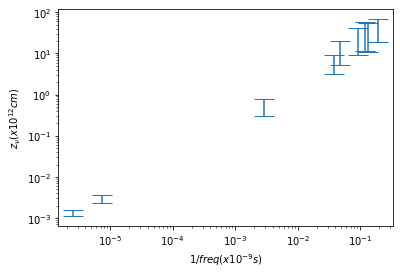

In [9]:
plt.errorbar(1/freq_array, z_array, yerr=asymmetric_error, fmt=' ', capsize=10)
plt.ylabel(r'$z_{\nu} (x10^{12} cm)$')
plt.xlabel(r'$1/freq (x10^{-9}s)$')
plt.xscale('log')
plt.yscale('log')

/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Multiprocess sampling (12 chains in 12 jobs)
NUTS: [beta, alpha]


Sampling 12 chains for 1_000 tune and 10_000 draw iterations (12_000 + 120_000 draws total) took 39 seconds.
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  from ipykernel import kernelapp as app
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

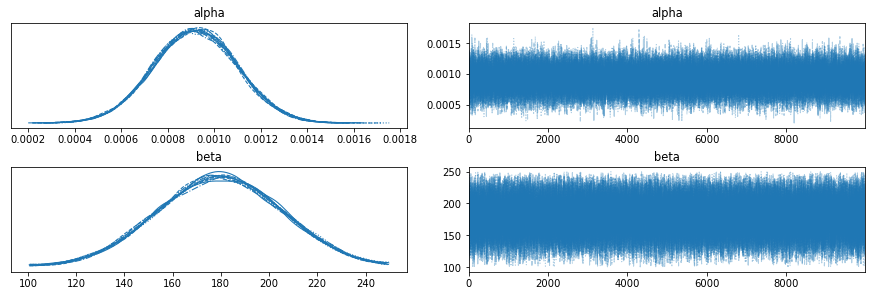

In [10]:
basic_model =  pm.Model()
with basic_model as bm:
    
    #alpha = pm.Normal('alpha', mu=0, sd=2)
    #beta = pm.Normal('beta', mu=0, sd=2)
    alpha = pm.Uniform('alpha', lower=-1, upper=2)
    beta = pm.Uniform('beta', lower=100, upper=250)
    
    mu = alpha +  beta*1/freq_array
    
    Ylikelihood = pm.Normal('ylikelihood', mu=mu, sd=asymmetric_error, observed = z_array)
    
    step_method = pm.NUTS()
    trace = pm.sample(10000, chains=12, cores=12, tune=1000,model=bm, step=step_method)
pm.traceplot(trace)

[196.64654634  -0.370614  ]


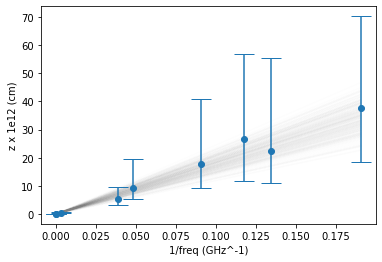

In [11]:
plt.errorbar(1/freq_array, z_array, yerr=asymmetric_error, fmt=' ', capsize=10, zorder=100)
plt.scatter(1/freq_array, z_array, zorder=100)

plt.xlabel("1/freq (GHz^-1)")
plt.ylabel("z x 1e12 (cm)")

popt, pcov = curve_fit(f, 1/freq_array, z_array)
print(popt)
x_array = np.linspace(min(1/freq_array), max(1/freq_array), 100)
y_array = f(x_array, popt[0], popt[1])
#plt.plot(x_array, y_array, color='black')


alpha_m = trace['alpha'].mean()
beta_m = trace['beta'].mean()
for i in range(200):
    alpha = mc_trace_sampler(trace['alpha'])
    beta = mc_trace_sampler(trace['beta'])
    plt.plot(1/freq_array, alpha+ beta *(1/freq_array), c='gray', alpha=0.01);

#plt.xscale('log')
#plt.yscale('log')


In [12]:
## read mcmc astrometry trace
with open('18202Dtrace.pickle', 'rb') as handle:
    J1820_trace_2D = pickle.load(handle)
with open('18201Dtrace.pickle', 'rb') as handle:
    J1820_trace_1D = pickle.load(handle)
    
jet_size_trace_sky = []
jet_size_trace_jetdirection = []

parsec2au = 206265

for i in tqdm(range(1000)):
    ra_coreshift = mc_trace_sampler(J1820_trace_2D['ra shift'])*3.6e6 #mas
    dec_coreshift = mc_trace_sampler(J1820_trace_2D['dec shift'])*3.6e6 #mas
    
    cs_theta_perp_t, cs_theta_para_t = jet_coordinates(ra_coreshift\
                                             , dec_coreshift, J1820_jet_angle)

    
    #total_coreshift = np.sqrt(ra_coreshift**2 + dec_coreshift**2)
    total_coreshift = cs_theta_para_t
    core_shift_radians = np.radians(total_coreshift*1e-3/3600) ## mas to rad
    
    ## get distance to source (in au as final product)
    parallax = mc_trace_sampler(J1820_trace_1D["parallax"])*1e-3 #asec
    dist_parsec = 1/parallax
    dist_au = dist_parsec*parsec2au
    
    #s=rxtheta
    jet_size_skyplane = dist_au*core_shift_radians #units au
    
    ## reproject along the jet axis
    jet_size_jetdirection = jet_size_skyplane/np.sin(np.radians(mc_normal_sampler(63, 3)))
    
    jet_size_trace_sky.append(jet_size_skyplane)
    jet_size_trace_jetdirection.append(jet_size_jetdirection*-1) ## note minus one cos we are measuring the offset to c band data
    ## explaination for flipping the sign
    # abouve we plot the correction dont to c band (downstream) to bring it in the same reference frame as 15ghz obser
    # as the thete perp gives values in the positive direction (direction going form 15Ghz to 5Ghz), the upper limit on the 
    # jet size is the negative of the core-shift correction.

100%|██████████| 1000/1000 [00:00<00:00, 1465.78it/s]


In [13]:
### calulate the jet size between 5 - 15 GHz
boot_strap_trace = []

cm2au = 6.68459e-14
for i in range(1000):
    alpha = mc_trace_sampler(trace['alpha'])
    beta = mc_trace_sampler(trace['beta'])
    jet_size = beta *(1/5) - beta *(1/15)
    boot_strap_trace.append(jet_size*1e12*cm2au)
    

Text(1.3612799029548488, 100, '1.3603')

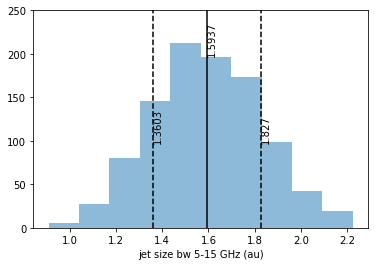

In [14]:
plt.hist(boot_strap_trace, alpha=0.5)
plt.xlabel('jet size bw 5-15 GHz (au)')
plt.vlines(np.mean(boot_strap_trace) - np.std(boot_strap_trace), 0, 250, color='black', linestyle='dashed')
plt.vlines(np.mean(boot_strap_trace) + np.std(boot_strap_trace), 0, 250, color='black', linestyle='dashed')
plt.vlines(np.mean(boot_strap_trace), 0, 250, color='black', linestyle='solid')
plt.ylim(0, 250)
var = np.copy(boot_strap_trace)
plt.text(np.mean(var)+0.001, 200, round(np.mean(var),4), rotation=90)
plt.text(np.mean(var)+np.std(var)+0.001, 100, round(np.mean(var)+np.std(var),4), rotation=90)
plt.text(np.mean(var)-np.std(var)+0.001, 100, round(np.mean(var)-np.std(var),4), rotation=90)


### scale down jet size using luminosity jet size relationship

In [15]:
peak5GHz_intensity1820 = [ 1.55 , 0.16,  0.13, 3.86, 4.09, 1.00]
peak5GHz_intensity1820err = [0.05, 0.03, 0.02, 0.05, 0.05, 0.05 ]

boot_strap_trace2 = []
luminosity_factor_trace = []
boot_strap_trace = []
vlbi_mean_trace = []

for i in tqdm(range(1000)):
    vlbi_light = []
    for epoch in range(len(peak5GHz_intensity1820)):
        peak_intensity = mc_normal_sampler(peak5GHz_intensity1820[epoch],\
                                           peak5GHz_intensity1820err[epoch])
        vlbi_light.append(peak_intensity)
    
    vlbi_mean = np.mean(vlbi_light)
    vlbi_mean_trace.append(vlbi_mean)
    Tetarenko_mean = mc_normal_sampler(46.0, 0.1)
    luminosity_factor = vlbi_mean/Tetarenko_mean
    luminosity_factor_trace.append(luminosity_factor)
    
    
    alpha = mc_trace_sampler(trace['alpha'])
    beta = mc_trace_sampler(trace['beta'])
    jet_size = beta *(1/5) - beta *(1/15)
    
    ## scaled down jet size
    new_jet_size = jet_size*(luminosity_factor)**(8/17)
    boot_strap_trace2.append(new_jet_size*1e12*cm2au)
    boot_strap_trace.append(jet_size*1e12*cm2au)
    

factor_mean = np.mean(luminosity_factor_trace)
factor_std = np.std(luminosity_factor_trace)
print('luminosity factory {} +- {}'.format(factor_mean, factor_std))

100%|██████████| 1000/1000 [00:02<00:00, 395.86it/s]

luminosity factory 0.039099549756370804 +- 0.00039715781244249396


In [16]:
print(np.mean(vlbi_mean_trace))
print(np.std(vlbi_mean_trace))

1.7985872792393864
0.017915942428488634


Text(0.3032096223059742, 100, '0.3022')

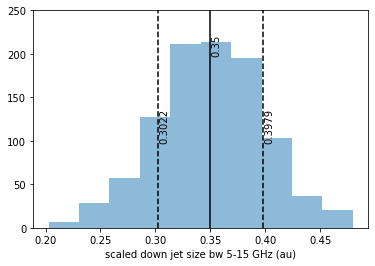

In [17]:
plt.hist(boot_strap_trace2, alpha=0.5)
plt.xlabel('scaled down jet size bw 5-15 GHz (au)')
plt.vlines(np.mean(boot_strap_trace2) - np.std(boot_strap_trace2), 0, 250, color='black', linestyle='dashed')
plt.vlines(np.mean(boot_strap_trace2) + np.std(boot_strap_trace2), 0, 250, color='black', linestyle='dashed')
plt.vlines(np.mean(boot_strap_trace2), 0, 250, color='black', linestyle='solid')
plt.ylim(0, 250)
var = np.copy(boot_strap_trace2)
plt.text(np.mean(var)+0.001, 200, round(np.mean(var),4), rotation=90)
plt.text(np.mean(var)+np.std(var)+0.001, 100, round(np.mean(var)+np.std(var),4), rotation=90)
plt.text(np.mean(var)-np.std(var)+0.001, 100, round(np.mean(var)-np.std(var),4), rotation=90)


### figure for paper

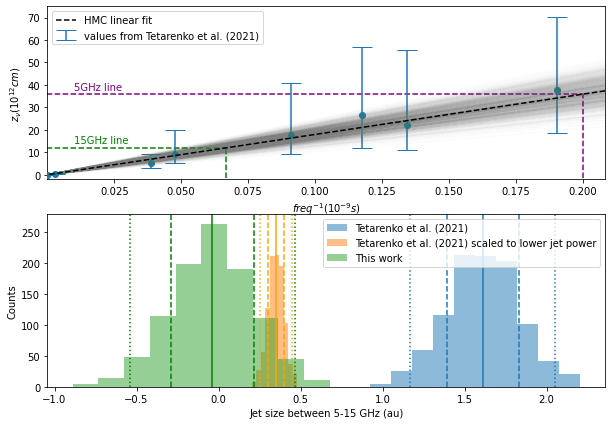

In [23]:

fig, ax = plt.subplots(2,1, figsize=(10,7), gridspec_kw={"wspace": 0.1})


ax[0].errorbar(1/freq_array, z_array, yerr=asymmetric_error, fmt=' ', capsize=10, zorder=100, label='values from Tetarenko et al. (2021)')
ax[0].scatter(1/freq_array, z_array, zorder=100)
ax[0].set_ylabel(r'$z_{\nu} (10^{12} cm)$')
ax[0].set_xlabel(r'$freq^{-1} (10^{-9}s)$')

popt, pcov = curve_fit(f, 1/freq_array, z_array)

x_array = np.linspace(min(1/freq_array), max(1/freq_array), 100)
y_array = f(x_array, popt[0], popt[1])
#plt.plot(x_array, y_array, color='black')

## do insert plot
#axins = zoomed_inset_axes(ax[0], 25, loc=2)
#x1, x2, y1, y2 = -0.0005, 0.0035, -0.1, 1.0
#axins.set_xlim(x1, x2)
#axins.set_ylim(y1, y2)

#patch, pp1, pp2, = mark_inset(ax[0], axins, loc1=1, loc2=3, fc="none", ec="black")
#pp1.loc1 = 4 #1
#mark_inset(ax[0], axins, loc1=3, loc2=4,  zorder=0)
#axins.errorbar(1/freq_array, z_array, yerr=asymmetric_error, fmt=' ', capsize=10, zorder=100)
#axins.scatter(1/freq_array, z_array, zorder=100)
#axins.set_yticks([])
#axins.set_xticks([])
freq2_array = np.concatenate((np.array([4]), freq_array))

alpha_m = trace['alpha'].mean()
beta_m = trace['beta'].mean()
ax[0].plot(1/freq2_array, alpha_m+ beta_m *(1/freq2_array), c='black', alpha=1, linestyle='dashed', label='HMC linear fit',zorder=1000)
ax[0].vlines(1/5, -5,alpha_m+ beta_m*(1/5) , color='purple',linestyle='dashed', alpha=1)
ax[0].hlines(alpha_m+ beta_m*(1/5), -2, 1/5 , color='purple', linestyle='dashed', alpha=1)
ax[0].vlines(1/15, -5,alpha_m+ beta_m*(1/15) , color='green', linestyle='dashed', alpha=1)
ax[0].hlines(alpha_m+ beta_m*(1/15), -2, 1/15 , color='green', linestyle='dashed', alpha=1)
ax[0].text(1/100, alpha_m+ beta_m*(1/5) +2, '5GHz line', color='purple')
ax[0].text(1/100, alpha_m+ beta_m*(1/15)+2 , '15GHz line', color='green')
#axins.plot(1/freq_array, alpha_m+ beta_m *(1/freq_array), c='black', alpha=1, linestyle='dashed')


for i in range(1000):
    alpha = mc_trace_sampler(trace['alpha'])
    beta = mc_trace_sampler(trace['beta'])
    ax[0].plot(1/freq2_array, alpha+ beta *(1/freq2_array), c='gray', alpha=0.01, zorder=100)

# for i in range(1000):
#     #trace
#     alpha = mc_trace_sampler(trace['alpha'])
#     beta = mc_trace_sampler(trace['beta'])
#     #ax[0].vlines(1/5, 0,alpha+ beta*(1/5) , color='purple',linestyle='solid', alpha=0.01, zorder=0)
#     ax[0].hlines(alpha+ beta*(1/5), -2, 1/5 , color='purple', linestyle='solid', alpha=0.01,zorder=0)
#     #ax[0].vlines(1/15, 0,alpha+ beta*(1/15) , color='green', linestyle='solid', alpha=0.005,zorder=0)
#     ax[0].hlines(alpha+ beta*(1/15), -2, 1/15 , color='green', linestyle='solid', alpha=0.005,zorder=0)



ax[0].set_xlim(0.00000001, 1/4.8)
ax[0].set_ylim(-2, 75)
ax[0].legend()


ax[1].hist(boot_strap_trace, alpha=0.5, label='Tetarenko et al. (2021)')
mean1 = np.mean(boot_strap_trace)
std1 = np.std(boot_strap_trace)
ax[1].vlines(mean1, 0, 300)
ax[1].vlines(mean1+std1, 0, 300, linestyle='dashed')
ax[1].vlines(mean1-std1, 0, 300, linestyle='dashed')
ax[1].vlines(mean1+2*std1, 0, 300, linestyle='dotted')
ax[1].vlines(mean1-2*std1, 0, 300, linestyle='dotted')


ax[1].hist(boot_strap_trace2, alpha=0.5, label='Tetarenko et al. (2021) scaled to lower jet power')
mean2 = np.mean(boot_strap_trace2)
std2 = np.std(boot_strap_trace2)
ax[1].vlines(mean2, 0, 300, color='orange')
ax[1].vlines(mean2+std2, 0, 300, color='orange', linestyle='dashed')
ax[1].vlines(mean2-std2, 0, 300, color='orange', linestyle='dashed')
ax[1].vlines(mean2+2*std2, 0, 300, color='orange', linestyle='dotted')
ax[1].vlines(mean2-2*std2, 0, 300, color='orange', linestyle='dotted')


ax[1].hist(jet_size_trace_jetdirection, alpha=0.5, label='This work')
mean3 = np.mean(jet_size_trace_jetdirection)
std3 = np.std(jet_size_trace_jetdirection)
ax[1].vlines(mean3, 0, 300, color='green')
ax[1].vlines(mean3+std3, 0, 300, color='green', linestyle='dashed')
ax[1].vlines(mean3-std3, 0, 300, color='green', linestyle='dashed')
ax[1].vlines(mean3+2*std3, 0, 300, color='green', linestyle='dotted')
ax[1].vlines(mean3-2*std3, 0, 300, color='green', linestyle='dotted')


ax[1].legend()

ax[1].set_xlabel('Jet size between 5-15 GHz (au)')
ax[1].set_ylabel('Counts')
ax[1].set_ylim(0,280)
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.savefig('1820JetSize.png', dpi=300)

In [19]:
mean2 = np.mean(boot_strap_trace2)
std2 = np.std(boot_strap_trace2)
print(mean2)
print(std2)

0.35004337410708913
0.047833751801114925


In [20]:
1/0.03911354603849593

25.566590127517212